## Preliminary Classification

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

#! pip install tensorflow
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# import norm
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle

AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display


import os
from os import listdir
from os.path import isfile, join
import pickle
import random
from out_of_the_box import Dense, Convolution, MyModel
#importing module
import sys
sys.path.insert(0, '../data')
from datahandler_multilabel import create_dataset



# to fix some warnings
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 999999999999 # Fix DecompressionBombWarning

## Preprocessing

Normalizing, setting aside a validation split and putting the data in the right format

In [2]:
with open('../data/filenames.pkl', 'rb') as infile:
    filenames = pickle.load(infile)
    
with open('../data/labels.pkl', 'rb') as infile2:
    labels = pickle.load(infile2)
    
df = pd.concat([pd.Series(filenames, name='filenames'), pd.Series(labels, name='labels')], axis=1)
df = shuffle(df, random_state=42)
print(df.shape, df.columns)

(24999, 2) Index(['filenames', 'labels'], dtype='object')


> Run the following cell only in case the dataset has been downloaded after January 2020

In [6]:
mypath = os.path.join('..','..','data_tate')
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] 

filenames1 = []
labels1 = []
for i,img_targ in enumerate(filenames):
    img_targ0 = img_targ.split('\\')[-1]
    if img_targ0 in onlyfiles:
        filenames1.append(str(img_targ))
        labels1.append(labels[i]) 
        
df = pd.concat([pd.Series(filenames1, name='filenames'), pd.Series(labels1, name='labels')], axis=1)
df = shuffle(df)
print(df.shape, df.columns)

(24999, 2) Index(['filenames', 'labels'], dtype='object')


In [3]:
#train test split
train_x = list(df['filenames'][:18000])
train_y = list(df['labels'][:18000])
val_x = list(df['filenames'][18000:21000])
val_y = list(df['labels'][18000:21000])
test_x = list(df['filenames'][21000:])
test_y = list(df['labels'][21000:])
print(len(train_x), len(train_y), len(val_x), len(val_y), len(test_x), len(test_y))

18000 18000 3000 3000 3999 3999


In [4]:
with open('../data/train_test_split.pkl', 'wb') as outfile:
    pickle.dump([train_x, train_y, val_x, val_y, test_x, test_y], outfile)

In [5]:
train_generator = create_dataset(train_x, train_y)
val_generator = create_dataset(val_x, val_y)
test_generator = create_dataset(test_x, test_y)

In [6]:
image_count = len(filenames)
image_count

24999

In [7]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 56 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time

In [7]:
train_generator

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 16)), types: (tf.float32, tf.float64)>

## Classification 

### Using VGG

In [10]:
feature_extractor_layer = {}
# VGG
feature_extractor_layer['VGG'] = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

### Using ResNet

In [16]:
feature_extractor_layer['ResNet'] = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

### Using InceptionV3

In [14]:
feature_extractor_layer['InceptionV3'] = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

Choose desired pretrained changing value of **pretrained**.

In [15]:
pretrained = 'ResNet'
feature_extractor_layer[pretrained].trainable = False
feature_extractor_layer[pretrained].summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [12]:
model = tf.keras.Sequential([
    feature_extractor_layer[pretrained],
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='sigmoid', name='output')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              2098176   
_________________________________________________________________
output (Dense)               (None, 16)                16400     
Total params: 25,702,288
Trainable params: 2,114,576
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

def mean_per_class_accuracy(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    per_class_acc = []
    per_class_acc.append(tf.cast(tf.math.count_nonzero(y_pred[i] * y[i], axis=0), tf.float32))
    mean_acc = tf.reduce_mean(per_class_acc)
    return mean_acc

def precision(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    pres = tp / (tp + fp + 1e-16)
    precision = tf.reduce_mean(pres)
    return precision

def recall(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    rec = tp / (tp + fn + 1e-16)
    recall = tf.reduce_mean(rec)
    return recall

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=["binary_accuracy",
                       "categorical_accuracy",
                       precision,
                       recall,
                       macro_f1
                      ])

In [ ]:
csv_logger = tf.keras.callbacks.CSVLogger('training_flat_multilabel_'+str(pretrained)+'.csv')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    'training_flat_multilabel'+str(pretrained)+'.h5', save_best_only=True,
            )

> If you wish to continue training an already partially trained model, run the following line: 

In [101]:
#pretrained = 'VGG'
#model = tf.keras.models.load_model('training_flat_multilabel'+str(pretrained)+'.h5', compile=False)

In [ ]:
model.fit(
        train_generator,
        epochs=30,
        validation_data = val_generator,
        callbacks = [csv_logger, checkpoint],
        #use_multiprocessing=True,
)

### Visualization and Evaluation

In [ ]:
pred = model.predict_generator(test_generator, verbose=1)
model.evaluate(test_generator, verbose=2)
print(pred.shape)

In [10]:
predicted_class_indices = np.where(pred > 0.5, 1, 0)
print(predicted_class_indices)
labels_dict = {0:'people',1:'objects',2:'places',3:'architecture',4:'abstraction',5:'society',\
          6:'nature',7:'emotions, concepts and ideas',8:'interiors',9:'work and occupations', \
          10:'symbols & personifications',11:'religion and belief',12:'leisure and pastimes',\
          13:'history',14:'literature and fiction',15:'group/movement'}
predictions = [[]]*len(predicted_class_indices)
actual = [[]]*len(test_y)
for k in range(len(predicted_class_indices)):
    predictions[k] = []
    actual[k] = []
    for i in range(len(predicted_class_indices[k])):
        if predicted_class_indices[k][i] == 1:
            predictions[k].append(labels_dict[i])
        if test_y[k][i] == 1:
            actual[k].append(labels_dict[i])
            
print(len(predictions), len(actual))

[[1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
3999 3999


In [11]:
results=pd.DataFrame({"Filename":test_x,
                      "Actual":actual,
                      "Predictions":predictions})
results.to_csv("results_Naive.csv",index=False)

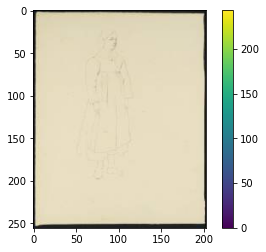

predicted as: ['people', 'objects'] 
actual class: ['people', 'objects']


In [23]:
number = random.randrange(0, 4000, 1)
results = pd.read_csv("results.csv")
img  = Image.open(str(results.Filename[number]))
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()
print('predicted as:', results.Predictions[number],
     '\nactual class:', results.Actual[number])

https://medium.com/towards-artificial-intelligence/understanding-multi-label-classification-model-and-accuracy-metrics-1b2a8e2648ca

In [92]:
def mean_per_class_accuracy(y, y_hat, num_classes):
    accuracy = [0]*num_classes
    for i in range(num_classes):
        accuracy[i] = 0
        for j in range(len(y)):
            if y[j][i] == y_hat[j][i]:
                accuracy[i] += 1
        accuracy[i] /= len(y)
    return accuracy

per_class_accuracy = mean_per_class_accuracy(
    test_y, predicted_class_indices, 16
)
per_class_accuracy

[0.5368842210552638,
 0.5011252813203301,
 0.6266566641660415,
 0.5573893473368342,
 0.5976494123530883,
 0.6349087271817955,
 0.49312328082020507,
 0.6479119779944986,
 0.8887221805451363,
 0.7489372343085772,
 0.8547136784196049,
 0.9199799949987497,
 0.8962240560140035,
 0.9362340585146287,
 0.9264816204051013,
 1.0]

In [94]:
def mean_per_item_accuracy(y, y_hat, num_classes):
    accuracy = [0]*len(y)
    for i in range(len(y)):
        accuracy[i] = 0
        for j in range(num_classes):
            if y[i][j] == y_hat[i][j]:
                accuracy[i] += 1
        accuracy[i] /= num_classes
    return sum(accuracy)/len(y)

per_item_accuracy = mean_per_item_accuracy(
    test_y, predicted_class_indices, 16
)
per_item_accuracy

0.7354338584646162

### Other random notes
For the following days: 
- experiment with data augmentation
- try out other regularization techniques
- try improving the addition of the pre-trained model
- deepen the current model

### Fine tuning

In [19]:
pretrained = 'ResNet'
feature_extractor_layer[pretrained].trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in feature_extractor_layer[pretrained].layers[:fine_tune_at]:
    layer.trainable =  False

feature_extractor_layer[pretrained].summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [17]:
model = tf.keras.Sequential([
    feature_extractor_layer[pretrained],
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='sigmoid', name='output')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 16)                16400     
Total params: 25,702,288
Trainable params: 12,104,720
Non-trainable params: 13,597,568
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=["binary_accuracy",
                       "categorical_accuracy",
                       #mean_per_class_accuracy,
                       precision,
                       recall,
                       macro_f1
                      ])

In [ ]:
csv_logger = tf.keras.callbacks.CSVLogger('training_flat_multilabel_'+str(pretrained)+'fine_tuned.csv')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    'training_flat_multilabel_'+str(pretrained)+'fine_tuned.h5', save_best_only=True,
            )

In [ ]:
model.fit(
        train_generator,
        epochs=30,
        validation_data = val_generator,
        callbacks = [csv_logger, checkpoint],
        #use_multiprocessing=True,
)

### Out of the box training

In [9]:
model = MyModel([64, 64, 128, 128],[128, 64, 16])

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=["binary_accuracy",
                       "categorical_accuracy",
                       #mean_per_class_accuracy,
                       precision,
                       recall,
                       macro_f1
                      ])

In [11]:
csv_logger = tf.keras.callbacks.CSVLogger('training_flat_multilabel_out_the_box.csv')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    'training_flat_multilabel_out_the_box.h5', save_best_only=True,
            )

In [ ]:
model.fit(
        train_generator,
        epochs=30,
        validation_data = val_generator,
        callbacks = [csv_logger, checkpoint],
        #use_multiprocessing=True,
)

Epoch 1/30
      2/Unknown - 70s 35s/step - loss: 1.3173 - binary_accuracy: 0.5497 - categorical_accuracy: 0.0536 - precision: 0.1991 - recall: 0.4051 - macro_f1: 0.2209

In [18]:
model.build(input_shape=(56,224,224,3))
model.summary()

Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution_2 (Convolution)  multiple                  261696    
_________________________________________________________________
dense_8 (Dense)              multiple                  2778320   
Total params: 3,040,016
Trainable params: 3,039,248
Non-trainable params: 768
_________________________________________________________________
